<a href="https://colab.research.google.com/github/HarshRangwala/DeepSort-Surveillance/blob/main/Kaggle_face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 6286, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 6286 (delta 37), reused 55 (delta 21), pack-reused 6205
Receiving objects: 100% (6286/6286), 8.54 MiB | 31.00 MiB/s, done.
Resolving deltas: 100% (4296/4296), done.


In [ ]:
!unzip '/content/drive/MyDrive/Kaggle mask.zip' -d '/content/drive/MyDrive/Data'

Archive:  /content/drive/MyDrive/Kaggle mask.zip
replace /content/drive/MyDrive/Data/label_map.pbtxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [ ]:
!mkdir -p Dataset/FaceMask/Images
!mkdir -p Dataset/FaceMask/Labels

In [ ]:
!cp -rf '/content/drive/MyDrive/Data/medical-masks-dataset/images/'* Dataset/FaceMask/Images

In [ ]:
!mkdir -p Dataset/images Dataset/labels

# Create dataset

In [ ]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [ ]:
FILE_ROOT = '/content/drive/MyDrive/Data/medical-masks-dataset/'
IMAGE_PATH = FILE_ROOT + "images"
LABEL_PATH = FILE_ROOT + "labels"

DATA_ROOT = "Dataset/"
IMAGE_ROOT = DATA_ROOT + "FaceMask/Images"
LABELS_ROOT = DATA_ROOT + "FaceMask/Labels"

DEST_IMAGE_PATH = "images"
DEST_LABEL_PATH = "labels"

In [ ]:
classes = ['mask', 'none', 'poor']

In [ ]:
def cord_converter(size, box):
    """Takes as input:  (width, height) of an image
                        (xmin, ymin, xmax, ymax) of the bounding box
       and returns (x, y, w, h) of the bounding box in yolo format.
    """   
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))
    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [ ]:
def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    file_path = open(save_file_name, "a+")
    for box in img_box:
        # print("BOX", box)
        cls_num = classes.index(box[0])
        # print(cls_num)
        new_box = cord_converter(size, box[1:])
        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")
    file_path.flush()
    file_path.close()
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir(LABEL_PATH)
for file in files:
    file_xml = file.split(".")
    get_xml_data(LABEL_PATH, file_xml[0])

In [ ]:
LABEL_PATH

'/content/drive/MyDrive/Data/medical-masks-dataset/labels'

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('Dataset/FaceMask/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)

print('total:',len(image_list))
print('train:',len(train_list))
print('val:',len(val_list))
print('test:',len(test_list))

total: 1148
train: 918
val: 115
test: 115


In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, type):
    root_file = Path(DATA_ROOT + DEST_IMAGE_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)
    root_file = Path(DATA_ROOT + DEST_LABEL_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)
    for file in file_list:
        img_name = file.replace('.jpg', '')
        img_src_file = imgs_source + '/' + img_name + '.jpg'
        label_src_file = img_labels_root + '/' + img_name + '.txt'
        DICT_DIR = DATA_ROOT + DEST_IMAGE_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.jpg'
        copyfile(img_src_file, img_dict_file)
        DICT_DIR = DATA_ROOT + DEST_LABEL_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
copy_data(train_list, LABELS_ROOT, IMAGE_ROOT, "train")
copy_data(val_list,   LABELS_ROOT, IMAGE_ROOT, "val")
copy_data(test_list,  LABELS_ROOT, IMAGE_ROOT, "test")

Path Dataset/images/train is not exit
Path Dataset/labels/train is not exit
Path Dataset/images/val is not exit
Path Dataset/labels/val is not exit
Path Dataset/images/test is not exit
Path Dataset/labels/test is not exit


In [ ]:

!echo "train: Dataset/images/train " > Dataset/facemask.yaml
!echo "val:   Dataset/images/val " >> Dataset/facemask.yaml
!echo "nc : 3 " >> Dataset//facemask.yaml
!echo "names: ['mask', 'none', 'poor'] " >> Dataset/facemask.yaml

!cat Dataset/facemask.yaml

train: Dataset/images/train 
val:   Dataset/images/val 
nc : 3 
names: ['mask', 'none', 'poor'] 


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images

In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 645kB 8.1MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!python train.py --img 320 --batch 20 --epochs 130 --data /content/Dataset/facemask.yaml --cfg /content/yolov5/models/yolov5s.yaml --weights yolov5s.pt

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-90-g06372b1 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=20, bbox_interval=-1, bucket='', cache_images=False, cfg='/content/yolov5/models/yolov5s.yaml', data='/content/Dataset/facemask.yaml', device='', entity=None, epochs=130, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=20, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-05-13 10:34:21.175685: I tensorflow/stream_executor/platform/

In [ ]:
!cp -rf '/content/drive/MyDrive/Data/medical-masks-dataset/images/'* Dataset/FaceMask/Images

In [ ]:
!python detect.py --source /content/Dataset/images/test --img-size 320 --conf 0.4 --weights runs/train/exp2/weights/best.pt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=320, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='/content/Dataset/images/test', update=False, view_img=False, weights=['runs/train/exp2/weights/best.pt'])
YOLOv5 🚀 v5.0-90-g06372b1 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPS
image 1/115 /content/Dataset/images/test/003_1024.jpg: 192x320 3 masks, Done. (0.009s)
image 2/115 /content/Dataset/images/test/022814asiatodaymasks_960x540.jpg: 192x320 4 masks, 1 none, 1 poor, Done. (0.008s)
image 3/115 /content/Dataset/images/test/1024x737_09186876046.jpg: 256x320 6 masks, 2 nones, Done. (0.009s)
image 4/115 /content/Dataset/images/test/104_mask.jpg: 224x320 1 mask, 1 none, Done. (0.009s)
image 5/115 /content/Dat

<function matplotlib.pyplot.show>

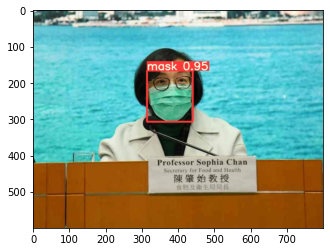

In [ ]:
# display detected images
from IPython.display import Image
from glob import glob
import matplotlib.pyplot as plt
testfiles = glob('runs/detect/exp2/*')

img = plt.imread(testfiles[0]) 
plt.imshow(img)    
plt.show
